In [1]:
# Импортируем библиотеки

from pandas import Series
import pandas as pd
import numpy as np
from datetime import date


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/train.csv


In [3]:
#Setting the conditions for experiments.
rsndom_seed = 42
data_directory = '/kaggle/input/sf-dst-scoring/'
!pip freeze > requirements.txt

In [4]:
# Импорт данных
data_train = pd.read_csv(data_directory+'train.csv')
data_test = pd.read_csv(data_directory+'test.csv')
#sample_submission = pd.read_csv(data_directory+'/sample_submission.csv')

In [5]:
# Объединим в общий датасет
data_train['sample'] = 1 #трейн
data_test['sample'] = 0 # тест
train = data_train.append(data_test, sort=False).reset_index(drop=True)

# Предобработка

In [6]:
train['education_is_nan'] = pd.isna(train['education']).astype('uint8')

In [7]:
def univariate_categorical(feature,ylog=False,label_rotation=False,horizontal_layout=True):
    train1 = train[train['sample'] == 1]
    temp = train1[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = train1[[feature, 'default']].groupby([feature],as_index=False).mean()
    cat_perc["default"] = cat_perc["default"]*100
    cat_perc.sort_values(by='default', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,24))
        
    # 1. Subplot 1: Count plot of categorical column

    s = sns.countplot(ax=ax1, 
                    x = feature, 
                    data=train1,
                    hue ="default",
                    order=cat_perc[feature],       
                    palette=['g','r'])
    
    # Define common styling
    ax1.set_title(feature, fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'}) 
    ax1.legend(['Repayer','Defaulter'])
    
    # If the plot is not readable, use the log scale.
    if ylog:
        ax1.set_yscale('log')
        ax1.set_ylabel("Count (log)",fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'})   
    
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    # 2. Subplot 2: Percentage of defaulters within the categorical column
    s = sns.barplot(ax=ax2, 
                    x = feature, 
                    y='default', 
                    order=cat_perc[feature], 
                    data=cat_perc,
                    palette='Set2')
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of Defaulters [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    ax2.set_title(feature + " Defaulter %", fontdict={'fontsize' : 15, 'fontweight' : 5, 'color' : 'Blue'}) 

    plt.show();
    

# EDA

## Посмотрим на переменные, которые содержит датасет:

client_id - идентификатор клиента

app_date - дата подачи заявки

education - уровень образования ('SCH', 'GRD', 'UGR', 'PGR', 'ACD')

sex - пол заёмщика ('F' - женский, 'M' - мужской)

age - возраст заёмщика

car - флаг наличия автомобиля ('Y' - да, 'N' - нет)

car_type - флаг автомобиля-иномарки ('Y' - да, 'N' - нет)

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия «хорошей» работы ('1' - да, '0' - нет)

score_bki - скоринговый балл по данным из БКИ

bki_request_cnt - количество запросов в БКИ

region_rating - рейтинг региона

home_address - категоризатор домашнего адреса (1, 2, 3)

work_address - категоризатор рабочего адреса (1, 2, 3)

income - доход заёмщика

sna - связь заемщика с клиентами банка

foreign_passport - наличие загранпаспорта ('Y' - да, 'N' - нет)

first_time - давность наличия информации о заемщике

default - наличие дефолта ('1' - да, '0' - нет)


In [8]:
display(train.describe(include='object'))
train.describe()

,app_date,education,sex,car,car_type,foreign_passport
count,110148,109670,110148,110148,110148,110148
unique,120,5,2,2,2,2
top,18MAR2014,SCH,F,N,N,N
freq,1491,57998,61836,74290,89140,93721


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,sample,education_is_nan
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999,0.004340
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215,0.065733
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000,1.000000


In [9]:
train.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
sample                  0
education_is_nan        0
dtype: int64

In [10]:
train.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
sample                   2
education_is_nan         2
dtype: int64

In [11]:
train.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
sample                   2
education_is_nan         2
dtype: int64

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Итого у нас: 110148 наблюдений. 18 признаков + целевая переменная. Пропущенные значения только в education. 

**числовые признаки**: client_id, age, decline_app_cnt, score_bki, bki_request_cnt, region_rating, income

**бинарные признаки**: sex, car, car_type, foreign_passport, good_work, default

**категориальные признаки**: education, home_address, work_address, first_time, sna

плюс **дата подачи**  app_date и **бинарный целевой признак**

### Рассмотрим признаки по отдельности

# 1. app_date - дата подачи заявки

In [13]:
# Добавим текущую дату
train['app_date']= pd.to_datetime(train['app_date'])
train.app_date.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


count                  110148
unique                    120
top       2014-03-18 00:00:00
freq                     1491
first     2014-01-01 00:00:00
last      2014-04-30 00:00:00
Name: app_date, dtype: object

In [14]:
# вычтем самую раннюю дату и преобразуем ее в дни
train['date_diff'] = train.app_date - train.app_date.min()
train['date_diff'] = train['date_diff'].dt.days
#Добавим день и месяц - может связь с началом - концом месяца будет...
train['month'] = train['app_date'].dt.month
train[train['sample'] == 1].groupby('default').month.describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0.0,64427.0,2.552470,1.090077,1.0,2.0,3.0,3.0,4.0
1.0,9372.0,2.431071,1.076444,1.0,1.0,2.0,3.0,4.0


In [15]:
#train['day'] = train['app_date'].dt.day
#не показал ничего хорошего

Период заявок с 1 января по 30 апреля 2014 года

# 2. client_id - идентификатор клиента

In [16]:
# уникальных значений
print(train['client_id'].nunique())
train.groupby('default').client_id.describe()
train.corr()['client_id']

110148


client_id           1.000000
age                 0.015535
decline_app_cnt    -0.021508
good_work           0.003447
score_bki          -0.061653
bki_request_cnt    -0.027428
region_rating       0.005720
home_address        0.163686
work_address        0.163422
income             -0.002069
sna                -0.001624
first_time          0.016865
default            -0.039242
sample              0.002844
education_is_nan   -0.008685
date_diff           0.999581
month               0.967146
Name: client_id, dtype: float64

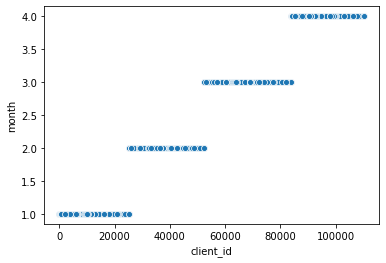

In [17]:
sns.scatterplot(x='client_id',y='month',data=train)

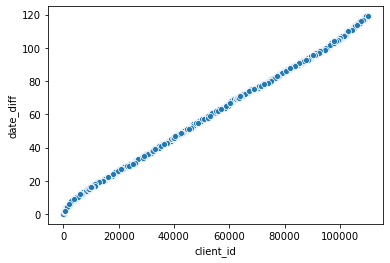

In [18]:
sns.scatterplot(x='client_id',y='date_diff',data=train)

id клиента имeет уникальное значение для каждого заемщика и присваивалось по порядку в зависимости от подачи заявки. Связи с присвоением номера и наличием дефолта - нет. Сильно коррелирует с признаками по дате подачи заявки

In [19]:
# Удалим его
train = train.drop('client_id', axis= 1)

# 3. age -  возраст заёмщика

In [20]:
train.age.describe()

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

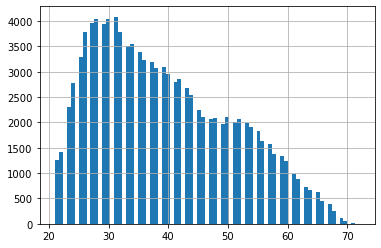

In [21]:
train['age'].hist(bins=77)

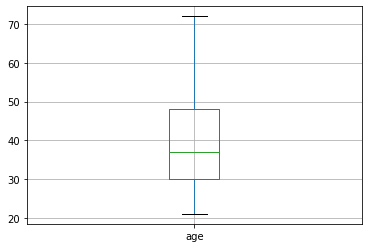

In [22]:
train.boxplot(column=['age'])

In [23]:
pd.DataFrame(train.age.value_counts()).head(15)

,age
31,4084
28,4035
30,4035
27,3964
29,3940
26,3780
32,3773
34,3548
33,3499
35,3386


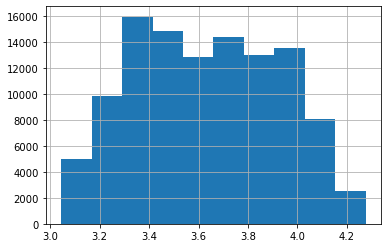

In [24]:
np.log(train['age']).hist()

в 25-39 люди чаще всего обращаются за кредитами. Что неудивительно. Но и пенсионеры могут обратиться в банк. Выбросы не ищем поэтому.
У распределения после логарифмирования исчезает правый хвост и оно становится ближе к нормальному

In [25]:
# Разобьем возраст на интервалы

bins = [20, 29, 39, 50, 72]
numbers = ['1','2','3', '4']

train['age_intervals']=pd.cut(train['age'],bins,labels=numbers)

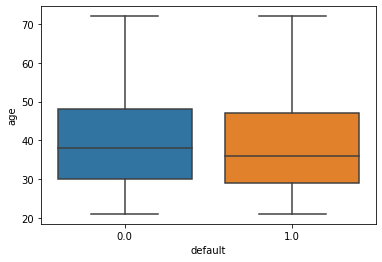

In [26]:
sns.boxplot(y = 'age', x = 'default', data=train)

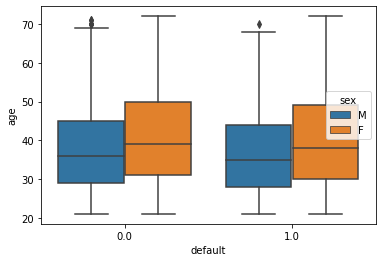

In [27]:
sns.boxplot(y = 'age', x = 'default', hue="sex", data=train)

С учетом того что мужчины как правило не уходят в декрет и больше работают - у них выше пенсия. но они живут меньше и... много факторов еще)

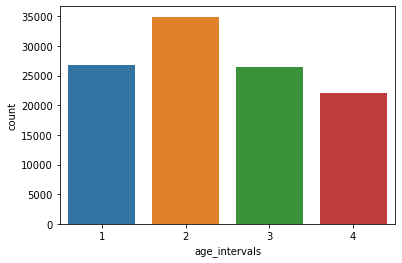

In [28]:
train.age_intervals.describe()

sns.countplot(train.age_intervals);

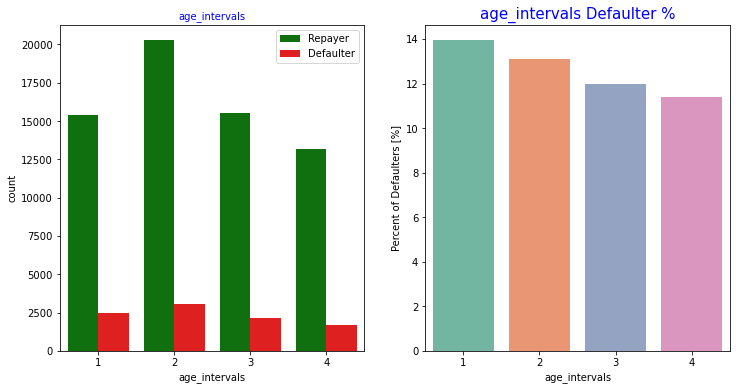

In [29]:
univariate_categorical('age_intervals', False,False,True)

# 4. sex - пол ученика ('F' - женский, 'M' - мужской)

,sex
F,61836
M,48312


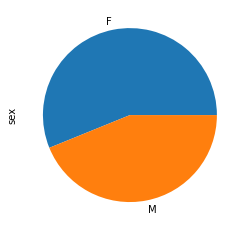

In [30]:
train['sex'].value_counts().plot(kind='pie')
display(pd.DataFrame(train.sex.value_counts()))

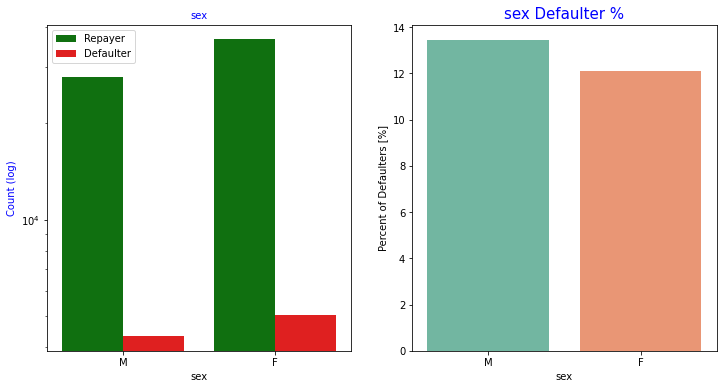

In [31]:
univariate_categorical('sex', True,False,True)

примерно 55% из заемщиков - женщины. При этом у них ниже процент дефолта в прошлом.

# 5. education - уровень образования ('SCH', 'GRD', 'UGR', 'PGR', 'ACD')

In [32]:
# Единственный столбец с пропущенными значениями
print(f'В данных {round(100* train.education.isna().sum() / len(train), 2)} % пропущенных значений')

В данных 0.43 % пропущенных значений


,education
SCH,0.528841
GRD,0.317024
UGR,0.134476
PGR,0.017006
ACD,0.002653


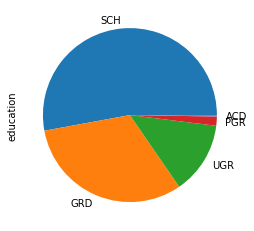

In [33]:
train['education'].value_counts().plot(kind='pie')
display(pd.DataFrame(train.education.value_counts(1)))

В данных почти 53 % имеют образование  SCH - по всей видиости школьное. В датасете есть доход. возможно он отражает образование

In [34]:
train.groupby('education').income.describe()

,count,mean,std,min,25%,50%,75%,max
education,,,,,,,,
ACD,291.0,85949.405498,78923.166247,3073.0,34300.0,65000.0,100000.0,500000.0
GRD,34768.0,54315.008916,57717.002841,1000.0,25000.0,40000.0,60000.0,1000000.0
PGR,1865.0,79753.214477,77743.130820,5000.0,39000.0,60000.0,100000.0,1000000.0
SCH,57998.0,32033.254681,32581.154483,1000.0,17000.0,25000.0,38000.0,1000000.0
UGR,14748.0,39009.904868,36962.662117,1000.0,20000.0,30000.0,45000.0,950000.0


In [35]:
#Посмотрим какой доход у пропущенных значений
train[train.education.isna() == True].income.describe()

count        478.000000
mean       46240.956067
std        66930.420691
min         5000.000000
25%        20000.000000
50%        30000.000000
75%        50000.000000
max      1000000.000000
Name: income, dtype: float64

 Очевидно что если у человека хорошее образование, то он укажет его в анкете, так как это может помочь при принятии решения банком. Исходя из сводной таблицы дохода и образования пропущенные значения можно заменить на SCH при доходе ниже 28 000 и UGR для оставшихся

In [36]:
train['education'] = train.apply(lambda x: ('SCH' if x.income <=28000 else 'UGR')\
                             if pd.isna(x.education) else x.education , axis=1)

In [37]:
#train['education'] = train.education.apply(lambda x: 'SCH' if  pd.isna(x) else x)

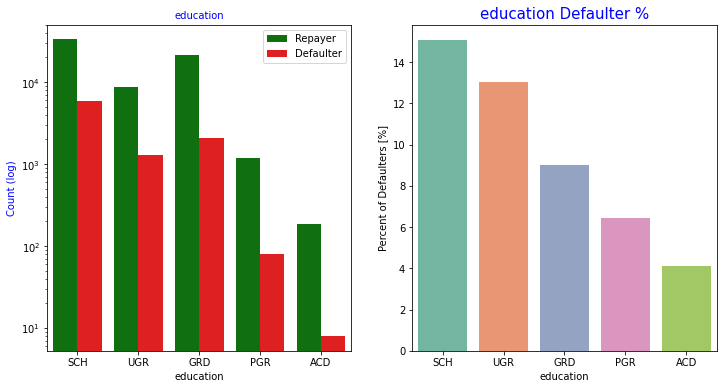

In [38]:
univariate_categorical('education', True,False,True)

In [39]:
# преобразуем в числа
train['education'] = train['education'].apply(lambda x: x.replace("SCH", '0').replace("GRD", '1').replace('UGR', '2').replace("PGR", '3').replace("ACD", '4'))
train['education'] = train['education'].apply(lambda x: int(x))

# 6. car - флаг наличия автомобиля ('Y' - да, 'N' - нет)

,car
N,74290
Y,35858


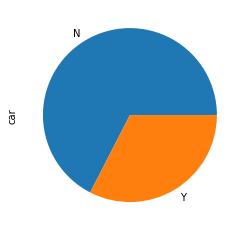

In [40]:
train['car'].value_counts().plot(kind='pie')
pd.DataFrame(train.car.value_counts())

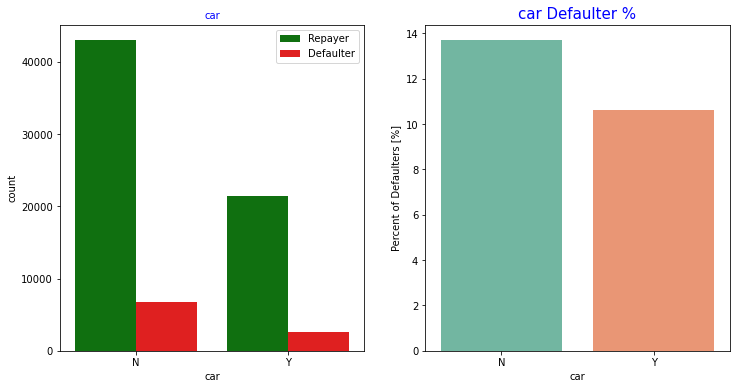

In [41]:
univariate_categorical('car', False,False,True)

Примерно треть заемщиков имеет машину. Наличие автомобиля снижает примерно на 3% невозврат кредита

# 7. car_type - флаг автомобиля-иномарки ('Y' - да, 'N' - нет)

,car_type
N,0.809275
Y,0.190725


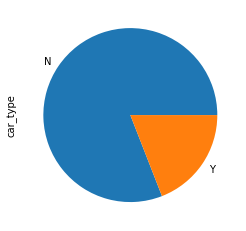

In [42]:
train['car_type'].value_counts().plot(kind='pie')
pd.DataFrame(train.car_type.value_counts(1))

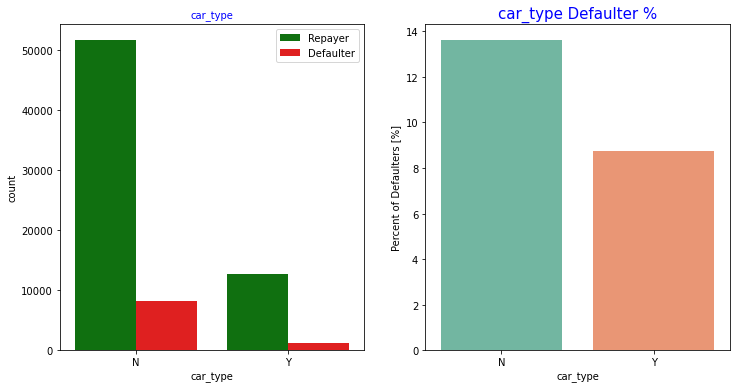

In [43]:
univariate_categorical('car_type', False,False,True)

Иномарка меньше чем у 19%. Но не иномарка стоит и у тех, у кого вовсе нет машины

In [44]:
pd.DataFrame(train[train.car == 'Y'].car_type.value_counts(1))

,car_type
Y,0.585866
N,0.414134


Т.е. иномарки составляют почти 58.5%

In [45]:
train['car_type2'] = train.apply(lambda x: ('0')\
                             if x.car == 'N' else x.car_type , axis=1)
train['car_type2'] = train['car_type2'].replace('Y', '2').replace('N', '1')
train['car_type2'] = train['car_type2'].apply(lambda x: int(x))

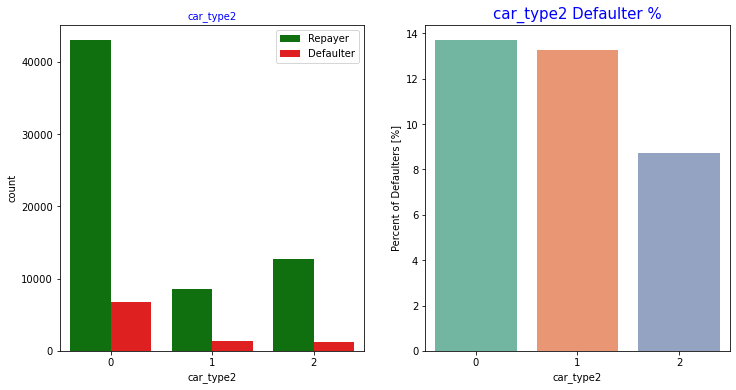

In [46]:
univariate_categorical('car_type2', False,False,True)

Среди обладателей машин - большая часть иномарки. Для банка это хорошая новость, так как снижает почти на 5% вероятноть дефолта по сравнению с тем, у кого нет машины. А вот отечественная машину почти не влияет на дефолт.

# 8. foreign_passport - наличие загранпаспорта ('Y' - да, 'N' - нет)

,foreign_passport
N,0.850864
Y,0.149136


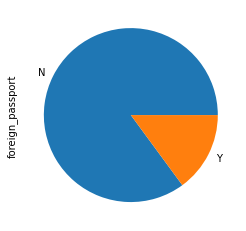

In [47]:
train['foreign_passport'].value_counts().plot(kind='pie')
pd.DataFrame(train.foreign_passport.value_counts(1))

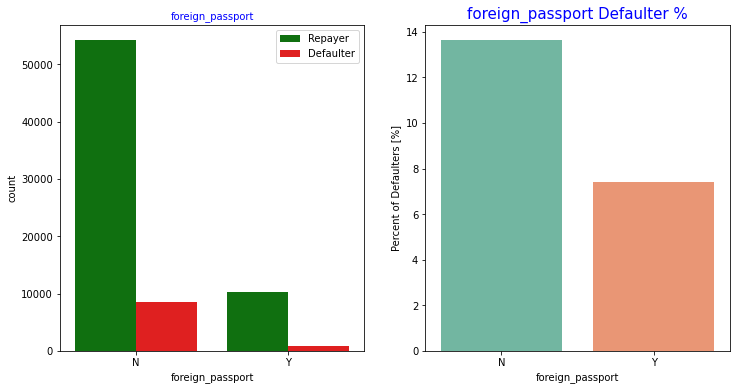

In [48]:
univariate_categorical('foreign_passport', False,False,True)

Почти 15 % человек имют загранпаспорт.что вдвое снижает вероятность дефолта

# 9. good_work - флаг наличия «хорошей» работы ('1' - да, '0' - нет)

,good_work
0,0.834486
1,0.165514


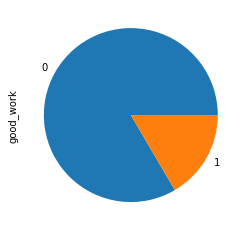

In [49]:
train['good_work'].value_counts().plot(kind='pie')
pd.DataFrame(train.good_work.value_counts(1))

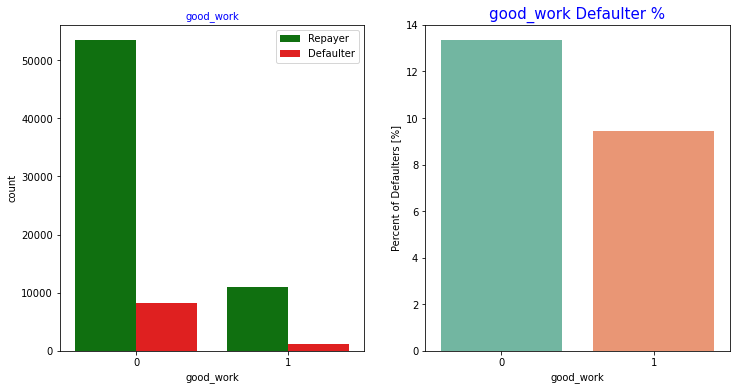

In [50]:
univariate_categorical('good_work', False,False,True)

Всего 16% начеления имет хорошую работу, что очевидно помогает им избежать дефолта

# 10. home_address - категоризатор домашнего адреса (1, 2, 3)

,home_address
2,0.541008
1,0.442023
3,0.016968


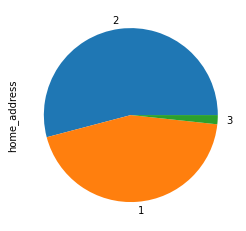

In [51]:
train['home_address'].value_counts().plot(kind='pie')
pd.DataFrame(train.home_address.value_counts(1))

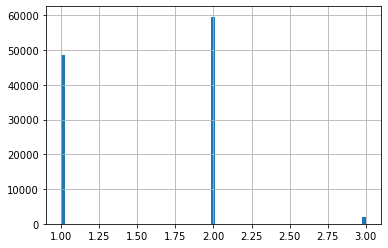

In [52]:
train.home_address.hist(bins=77)

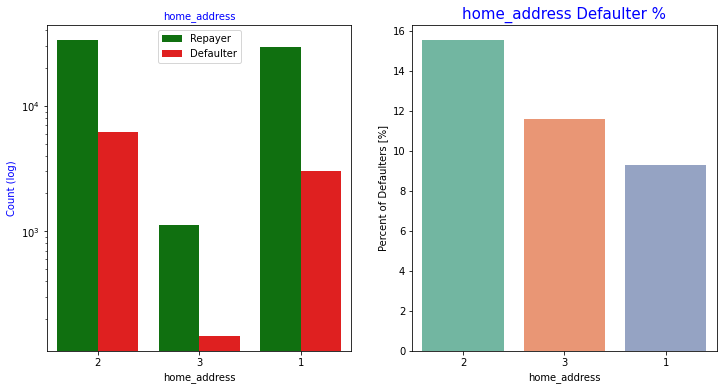

In [53]:
univariate_categorical('home_address', True,False,True)

# 11. work_address - категоризатор рабочего адреса (1, 2, 3)

,work_address
3,0.609298
2,0.279270
1,0.111432


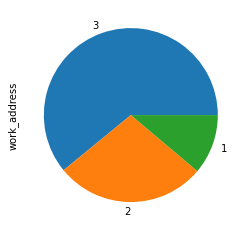

In [54]:
train['work_address'].value_counts().plot(kind='pie')
pd.DataFrame(train.work_address.value_counts(1))

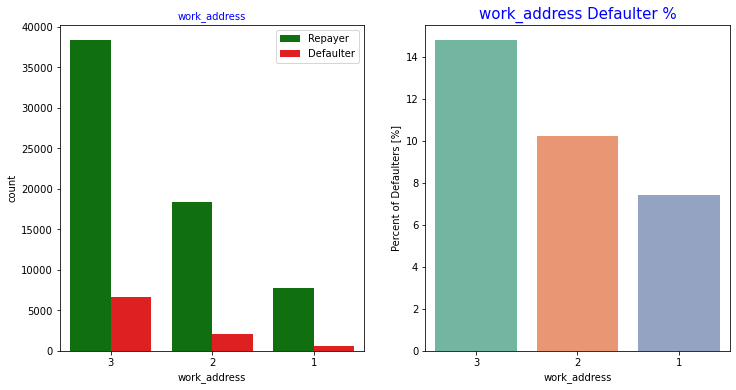

In [55]:
univariate_categorical('work_address', False,False,True)

Чем лучше работа, тем меньше вероятность дефолта. Что естественно

# 12. region_rating - рейтинг региона

In [56]:
train.region_rating.describe()

count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64

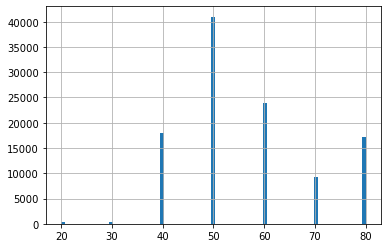

In [57]:
train.region_rating.hist(bins=77)

In [58]:
pd.DataFrame(train.region_rating.value_counts())

,region_rating
50,40981
60,23999
40,17947
80,17170
70,9304
30,434
20,313


In [59]:
train.groupby('region_rating').income.describe()

,count,mean,std,min,25%,50%,75%,max
region_rating,,,,,,,,
20,313.0,33854.747604,44654.259253,4600.0,15000.0,23679.0,35000.0,500000.0
30,434.0,30457.995392,37711.851690,5000.0,15000.0,22000.0,35000.0,600000.0
40,17947.0,33438.350811,38526.331855,1000.0,17000.0,25000.0,38950.0,1000000.0
50,40981.0,35042.573583,40121.588701,1000.0,18000.0,25000.0,40000.0,1000000.0
60,23999.0,37294.956457,41670.222866,1000.0,20000.0,30000.0,40000.0,1000000.0
70,9304.0,55714.572657,53430.807030,2400.0,30000.0,43000.0,60000.0,999999.0
80,17170.0,60805.944729,55734.578314,1700.0,35000.0,48000.0,70000.0,1000000.0


Чем выше рейтинг региона, тем выше доход. А значит и ниже вероятность дефолта

# 13. decline_app_cnt - количество отказанных прошлых заявок (от 0 до 33)

In [60]:
train.decline_app_cnt.describe()

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

In [61]:
# Посмотрим на количество отказанных завок 
pd.DataFrame(train.decline_app_cnt.value_counts())

,decline_app_cnt
0,91471
1,12500
2,3622
3,1365
4,606
5,255
6,156
7,58
8,37
9,29


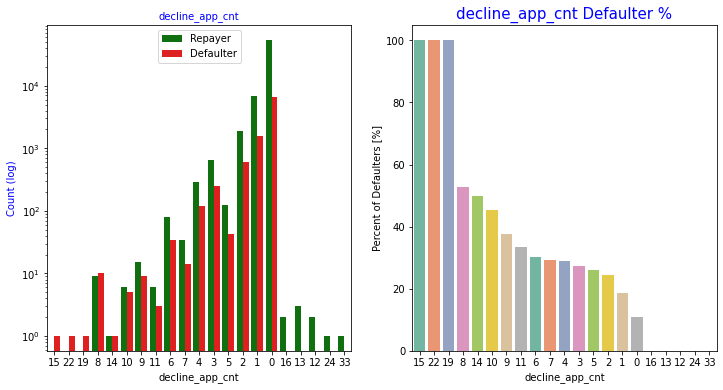

In [62]:
univariate_categorical('decline_app_cnt', True,False,True)

In [63]:
#ограничение выбросов не помогло
#train.decline_app_cnt = train.decline_app_cnt.apply(lambda x: 0 if x >= 5 else x)

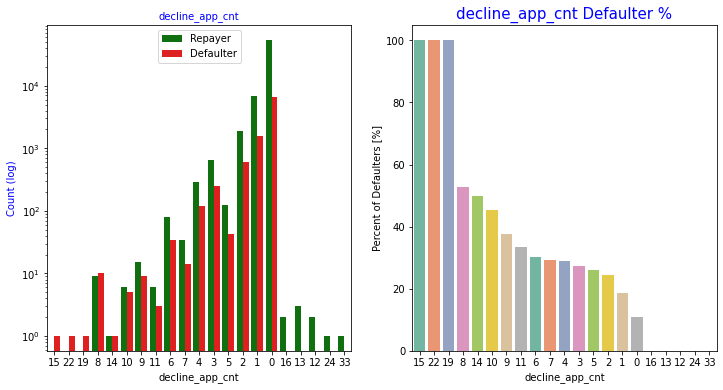

In [64]:
univariate_categorical('decline_app_cnt', True,False,True)

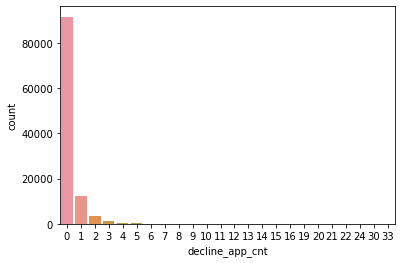

In [65]:
sns.countplot(x = 'decline_app_cnt', data = train);

# 14. bki_request_cnt - количество запросов в БКИ

In [66]:
train.bki_request_cnt.describe()

count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

In [67]:
median = train.bki_request_cnt.median()
IQR = train.bki_request_cnt.quantile(0.75) - train.bki_request_cnt.quantile(0.25)
perc25 = train.bki_request_cnt.quantile(0.25)
perc75 = train.bki_request_cnt.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{l}].".format(l=perc75 + 1.5*IQR))

25-й перцентиль: 0.0, 75-й перцентиль: 3.0, IQR: 3.0,  Границы выбросов: [7.5].


In [68]:
#train.bki_request_cnt = train.bki_request_cnt.apply(lambda x: 0 if x > 8 else x)


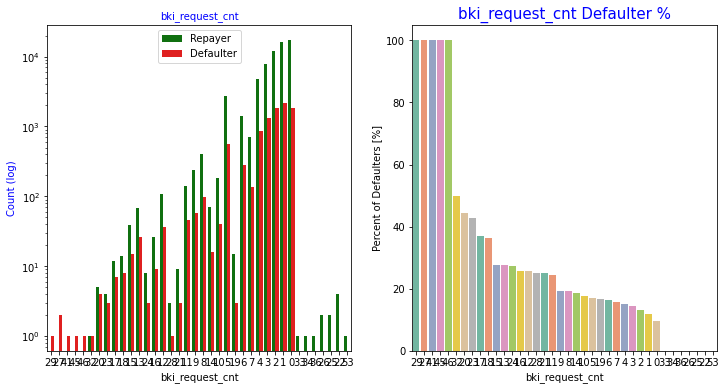

In [69]:
univariate_categorical('bki_request_cnt', True,False,True) 

Немного удивительно что люди с достаточно большими отказами все вернули.

# 15. score_bki - баллы в БКИ

In [70]:
train.score_bki.describe()

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64

In [71]:
train.groupby('default').score_bki.describe()

,count,mean,std,min,25%,50%,75%,max
default,,,,,,,,
0.0,64427.0,-1.938048,0.489903,-3.624586,-2.284749,-1.956982,-1.609687,0.199773
1.0,9372.0,-1.675637,0.494691,-3.456086,-2.015871,-1.683857,-1.337922,0.199773


Напрямую разницы не видно

# 16. income - доход заёмщика

In [72]:
train.income.describe()

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

Довольно большой разброс

In [73]:
# Разобьем возраст на интервалы

#bins = [0, 20000, 38000, 90000, 135000, 1000000]
#numbers = ['a','b','c', 'd', 'e']
#train['income_intervals']=pd.cut(train['income'],bins,labels=numbers)

In [74]:
#train['income_intervals'] = train['income_intervals'].apply(lambda x: x.replace("a", '1').replace("b", '2').replace('c', '3').replace("d", '4').replace("e", '4'))
#train['income_intervals'] = train['income_intervals'].apply(lambda x: int(x))
#train['income_intervals_per_edu'] = train.income_intervals / (train.education +1)

Это не дало результата

Учитывая что 75% людей имеет доход 48 000, 1 млн похож на выброс. Проверим

In [75]:
median = train.income.median()
IQR = train.income.quantile(0.75) - train.income.quantile(0.25)
perc25 = train.income.quantile(0.25)
perc75 = train.income.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{l}].".format(l=perc75 + 1.5*IQR))

25-й перцентиль: 20000.0, 75-й перцентиль: 48000.0, IQR: 28000.0,  Границы выбросов: [90000.0].


In [76]:
#train.income = train.income.apply(lambda x: 30000 if x > 90000 else x)

# 17. sna - связь заемщика с клиентами банка

In [77]:
train.sna.unique()

array([4, 1, 2, 3])

,sna
1,0.641691
4,0.158705
2,0.143734
3,0.055870


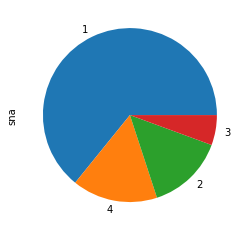

In [78]:
train['sna'].value_counts().plot(kind='pie')
display(pd.DataFrame(train.sna.value_counts(1)))

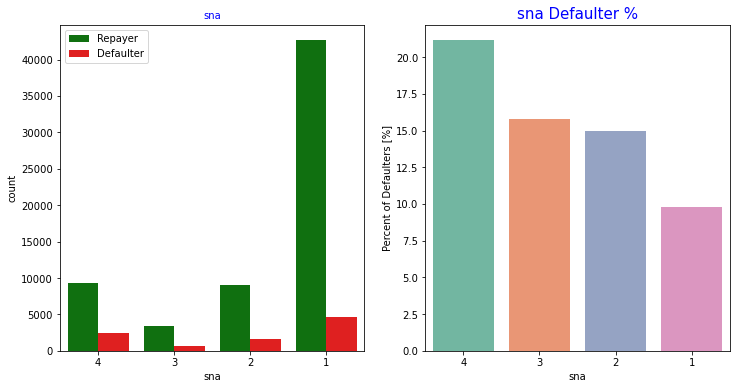

In [79]:
univariate_categorical('sna', False,False,True)

# 18. first_time - давность наличия информации о заемщике

,first_time
3,0.422958
4,0.254358
1,0.166104
2,0.156580


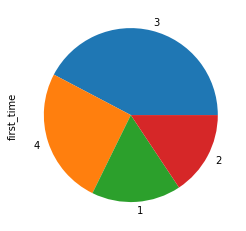

In [80]:
train['first_time'].value_counts().plot(kind='pie')
display(pd.DataFrame(train.first_time.value_counts(1)))

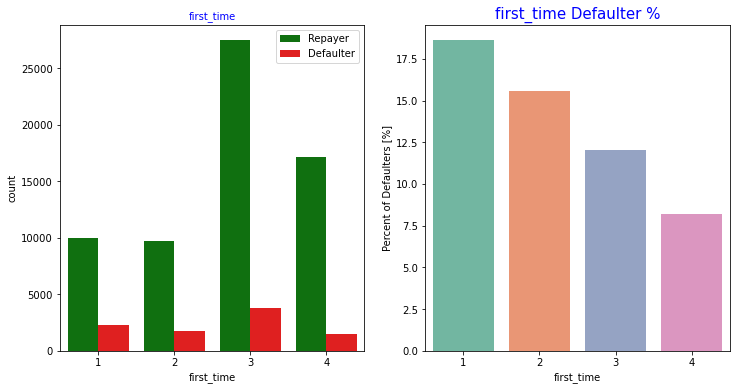

In [81]:
univariate_categorical('first_time', False,False,True)

Хорошая зависимость дефолта от признака

# 19. default - наличие дефолта ('1' - да, '0' - нет)

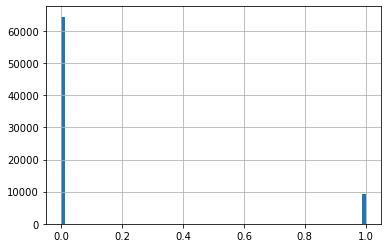

In [82]:
train['default'].hist(bins=77)

In [83]:
Имеем дело с несбалансированными данными

SyntaxError: invalid syntax (<ipython-input-83-6f824e2e6cdd>, line 1)

In [84]:
pd.DataFrame(train.groupby('default').agg('mean'))

,education,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,education_is_nan,date_diff,month,car_type2
default,,,,,,,,,,,,,,,,,
0.0,0.665963,39.390504,0.240877,0.171031,-1.938048,1.933134,57.169044,1.558477,2.474816,41799.713288,1.679405,2.806106,1.0,0.004222,61.517795,2.552470,0.530880
1.0,0.531797,38.525395,0.515472,0.122706,-1.675637,2.462335,53.677977,1.692595,2.643833,36288.113316,2.104033,2.486022,1.0,0.003735,57.719484,2.431071,0.402475


#  Подготовка признаков

In [85]:
train['bki_request_cnt'] = np.log(train['bki_request_cnt']+1)
train['decline_app_cnt'] = np.log(train['decline_app_cnt']+1)
train['income'] = np.log(train['income']+1)
train['age'] = np.log(train['age']+1)
#train['summ'] = train['good_work'] + train ['home_address'] + train ['region_rating'] + train['work_address']

In [86]:
# Групировка признаков
time_col = ['app_date']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'age_intervals', 'car_type2'] #, 'age_intervals']'car_type2',
bin_cols = ['sex', 'good_work', 'foreign_passport']# 'car', 'car_type',

num_cols = ['decline_app_cnt','score_bki','bki_request_cnt','income', 'date_diff', 'age'] # 'poly138', 'poly37', 'poly6', 'poly50', 'poly5'


Полиномиальные признаки н дали результата


pf = PolynomialFeatures(2)
poly_df = pf.fit_transform(train[['education', 'region_rating', 'home_address', 'work_address', 
                                 'sna', 'first_time', 'age_intervals', 'car_type2', 'good_work', 'foreign_passport', 'decline_app_cnt','score_bki',
                                 'bki_request_cnt','income', 'date_diff']])
poly_df1 = pd.DataFrame(poly_df)
poly_df1 = poly_df1.drop(0, axis=1)
#data['poly158'] = poly_df1[158]
#data['poly160'] = poly_df1[160]
#data['poly162'] = poly_df1[162]
poly_df1['default'] = train.default
poly_df1

train['poly138'] = poly_df1[138]
train['poly37'] = poly_df1[37]
train['poly6'] = poly_df1[6]
#train['poly43'] = poly_df[43]
train['poly12'] = poly_df1[12]
train['poly50'] = poly_df1[50]
train['poly5'] = poly_df1[5]


poly_df1.corr()['default'].sort_values().head(10)

poly_df1.corr()['default'].sort_values().tail(10)

# Корреляция

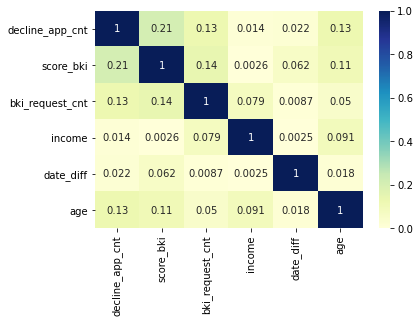

In [87]:
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot = True, cmap="YlGnBu")

Сильная корреляция, вредная для линейных моделей, в нашем случае только у признаков из дат. 

In [88]:
train.corr()['default']

education          -0.056181
age                -0.026119
decline_app_cnt     0.124027
good_work          -0.043361
score_bki           0.175369
bki_request_cnt     0.078501
region_rating      -0.089035
home_address        0.084637
work_address        0.081582
income             -0.053871
sna                 0.125832
first_time         -0.105579
default             1.000000
sample                   NaN
education_is_nan   -0.002521
date_diff          -0.039372
month              -0.037115
car_type2          -0.053890
Name: default, dtype: float64

In [89]:
# Удалим с меньшей корреляцией с целевой переменной
train = train.drop('month', axis=1)

# кодирование признаков

In [90]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(train['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [91]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
# убедимся в преобразовании    
train.head()

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,income,sna,first_time,foreign_passport,default,sample,education_is_nan,date_diff,age_intervals,car_type2
0,2014-02-01,0,1,4.143135,Y,Y,0.000000,0,-2.008753,0.693147,...,9.798183,4,1,0,0.0,1,0,31,4,2
1,2014-03-12,0,0,4.094345,N,N,0.000000,0,-1.532276,1.386294,...,9.852247,4,1,0,0.0,1,0,70,4,0
2,2014-02-01,0,1,3.258097,Y,N,1.098612,0,-1.408142,0.693147,...,10.308986,1,4,1,0.0,1,0,31,1,1
3,2014-01-23,0,0,3.988984,N,N,0.000000,0,-2.057471,1.098612,...,9.210440,1,3,0,0.0,1,0,22,4,0
4,2014-04-18,1,1,3.891820,N,N,0.000000,1,-1.244723,0.693147,...,10.308986,1,4,1,0.0,1,0,107,3,0


In [92]:

train = train.drop(['app_date'], axis=1) #, 'age_intervals'
train_df = train[train['sample']==1]

In [93]:
# признак type2 вроде покрывает оба этих признака
train = train.drop(['car', 'car_type'], axis=1) #, 'age_intervals'


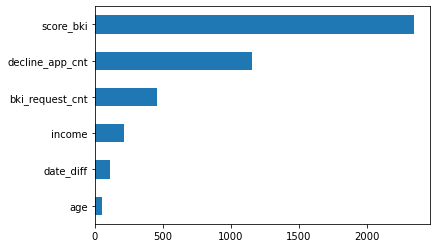

In [94]:
# Checking the importance of features.
imp_num = Series(f_classif(train_df[num_cols], 
                           train_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [95]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])

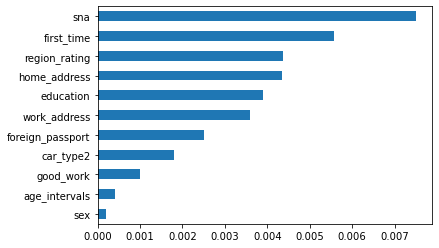

In [96]:
imp_cat = Series(mutual_info_classif(train_df[bin_cols + cat_cols], train_df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [97]:
train = pd.get_dummies(train, prefix=cat_cols, columns=cat_cols)

In [98]:
# Стандартизация числовых переменных
scaler = StandardScaler() #RobustScaler()

train[num_cols] = scaler.fit_transform(train[num_cols].values)

In [99]:
#Разбиение на выборки
train_data = train[train['sample'] == 1].drop(['sample'], axis=1)
test_data = train[train['sample'] == 0].drop(['sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

In [100]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_valid.shape

((36349, 44), (73799, 44), (73799, 43), (59039, 43), (14760, 43))

In [101]:
model = LogisticRegression(random_state=42, max_iter = 1000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

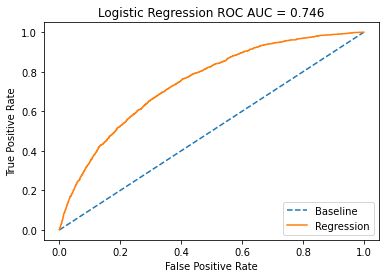

In [102]:
fpr, tpr, threshold = roc_curve(y_valid, y_pred_prob)
roc_auc = roc_auc_score(y_valid, y_pred_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [103]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
value = [accuracy_score(y_valid,y_pred), precision_score(y_valid,y_pred), recall_score(y_valid,y_pred), f1_score(y_valid,y_pred)]
first_metrics_df = pd.DataFrame({'Метрика': metrics, 'Значение': value}, columns=['Метрика', 'Значение'])

In [104]:

# матрица ошибок
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print(tp, fp) 
print(fn, tn)


44 60
1783 12873


45 - очень плохой результат для определения дефолтных клиентов. Имеем ошибку второго рода

In [105]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)

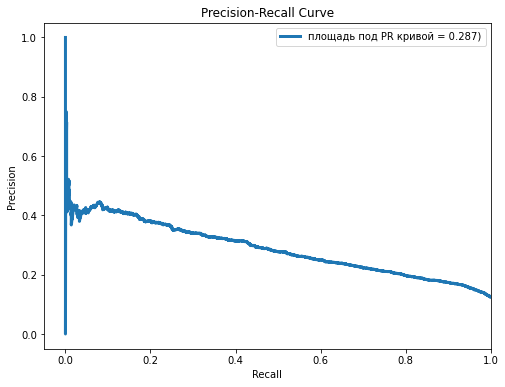

In [106]:
plt.figure(figsize=(8, 6))
prc_area = auc(recall, precision)
plt.plot(recall, precision, lw=3, label='площадь под PR кривой = %0.3f)' % prc_area)
    
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [107]:
add_metrics = pd.DataFrame({'Метрика': ['ROC_AUC', 'PRC_AUC'], 'Значение': [roc_auc, prc_area]}, columns=['Метрика', 'Значение'])

first_metrics_df = first_metrics_df.append(add_metrics, ignore_index=True)

In [108]:
first_metrics_df

,Метрика,Значение
0,accuracy,0.875136
1,precision,0.423077
2,recall,0.024083
3,f1_score,0.045572
4,ROC_AUC,0.745581
5,PRC_AUC,0.286648


In [109]:
print('Accuracy: %.4f' % accuracy_score(y_valid, y_pred))
print('Precision: %.4f' % precision_score(y_valid, y_pred))
print('Recall: %.4f' % recall_score(y_valid, y_pred))
print('F1: %.4f' % f1_score(y_valid, y_pred))

precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)
print('ROC_AUC = ', round(roc_auc_score(y_valid, y_pred_prob), 4))
print('PRC_AUC = ', round(auc(recall, precision), 4))

Accuracy: 0.8751
Precision: 0.4231
Recall: 0.0241
F1: 0.0456
ROC_AUC =  0.7456
PRC_AUC =  0.2866


In [110]:
model = LogisticRegression(random_state=42)

iter_max = 300

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
print(model)

LogisticRegression(class_weight='balanced', max_iter=300, penalty='l1',
                   random_state=42, solver='liblinear')


In [111]:
# Обучим модель на данных и проверим confusion_matrix

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)


In [112]:
# матрица ошибок
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print(tp, fp) 
print(fn, tn)

1253 4277
574 8656


In [113]:
print('Accuracy: %.4f' % accuracy_score(y_valid, y_pred))
print('Precision: %.4f' % precision_score(y_valid, y_pred))
print('Recall: %.4f' % recall_score(y_valid, y_pred))
print('F1: %.4f' % f1_score(y_valid, y_pred))

precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)
print('ROC_AUC = ', round(roc_auc_score(y_valid, y_pred_prob), 4))
print('PRC_AUC = ', round(auc(recall, precision), 4))

Accuracy: 0.6713
Precision: 0.2266
Recall: 0.6858
F1: 0.3406
ROC_AUC =  0.7451
PRC_AUC =  0.2859


In [114]:
# Метрики первой модели
first_metrics_df

,Метрика,Значение
0,accuracy,0.875136
1,precision,0.423077
2,recall,0.024083
3,f1_score,0.045572
4,ROC_AUC,0.745581
5,PRC_AUC,0.286648


# Submission

In [115]:
train_data = train[train['sample'] == 1].drop(['sample'], axis=1)
test_data = train[train['sample'] == 0].drop(['sample'], axis=1)

In [116]:
train.columns

Index(['sex', 'age', 'decline_app_cnt', 'good_work', 'score_bki',
       'bki_request_cnt', 'income', 'foreign_passport', 'default', 'sample',
       'education_is_nan', 'date_diff', 'education_0', 'education_1',
       'education_2', 'education_3', 'education_4', 'region_rating_20',
       'region_rating_30', 'region_rating_40', 'region_rating_50',
       'region_rating_60', 'region_rating_70', 'region_rating_80',
       'home_address_1', 'home_address_2', 'home_address_3', 'work_address_1',
       'work_address_2', 'work_address_3', 'sna_1', 'sna_2', 'sna_3', 'sna_4',
       'first_time_1', 'first_time_2', 'first_time_3', 'first_time_4',
       'age_intervals_1', 'age_intervals_2', 'age_intervals_3',
       'age_intervals_4', 'car_type2_0', 'car_type2_1', 'car_type2_2'],
      dtype='object')

In [117]:
X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [118]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 44), (73799, 44), (73799, 43), (73799,), (36349, 43))

In [119]:
model = LogisticRegression(random_state=42)

iter_max = 1000

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
print(model)

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')


In [120]:
y_pred = model.predict_proba(X_test)[:,1]

In [121]:
train.columns

Index(['sex', 'age', 'decline_app_cnt', 'good_work', 'score_bki',
       'bki_request_cnt', 'income', 'foreign_passport', 'default', 'sample',
       'education_is_nan', 'date_diff', 'education_0', 'education_1',
       'education_2', 'education_3', 'education_4', 'region_rating_20',
       'region_rating_30', 'region_rating_40', 'region_rating_50',
       'region_rating_60', 'region_rating_70', 'region_rating_80',
       'home_address_1', 'home_address_2', 'home_address_3', 'work_address_1',
       'work_address_2', 'work_address_3', 'sna_1', 'sna_2', 'sna_3', 'sna_4',
       'first_time_1', 'first_time_2', 'first_time_3', 'first_time_4',
       'age_intervals_1', 'age_intervals_2', 'age_intervals_3',
       'age_intervals_4', 'car_type2_0', 'car_type2_1', 'car_type2_2'],
      dtype='object')

In [122]:
submit = pd.DataFrame(data_test.client_id)
submit['default']=y_pred
submit.to_csv('submission.csv', index=False)
display(submit.head(10))

,client_id,default
0,74835,0.199158
1,17527,0.816871
2,75683,0.328210
3,26883,0.383396
4,28862,0.148554
5,99881,0.548908
6,26630,0.795140
7,79934,0.181012
8,16605,0.144230
9,105449,0.142926
